In [1]:
import open3d as o3d
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial import Delaunay
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# Function to create transects by selecting points around target theta2 values
def create_transects_around_target_theta2(point_cloud, target_theta2_values, theta_range=1.5):
    return [point_cloud[(point_cloud['theta'] >= target_theta2 - theta_range) & 
                        (point_cloud['theta'] <= target_theta2 + theta_range)] 
            for target_theta2 in target_theta2_values]

# Function to check if all values in the point_cloud_df have been assigned to a transect
def check_unassigned_points(point_cloud_df, transects):
    assigned_points = pd.concat(transects)
    return point_cloud_df[~point_cloud_df.index.isin(assigned_points.index)].shape[0]


In [3]:
# Load point cloud
map_naam = r"C:\Users\ruro\OneDrive - Boskalis\Documents\python\01-Fieldwork\Lidar\Alignment_test\HybridDune_Pcl_0001_01_1970__00_42_37.209.PCD"
pcd = o3d.io.read_point_cloud(map_naam)
pcd

PointCloud with 9333 points.

In [4]:
# Extract points as a NumPy array
xyz = np.asarray(pcd.points)

# Convert to spherical coordinates with the z-axis as the reference axis
x, y, z = xyz[:, 0], xyz[:, 1], xyz[:, 2]
rho = np.sqrt(x**2 + y**2 + z**2)
phi = np.arctan2(y, x)
theta_degrees = np.degrees(np.arccos(z / rho))

# Create a DataFrame to store the point cloud data along with theta values
point_cloud_df = pd.DataFrame({'x': x, 'y': y, 'z': z, 'theta': theta_degrees})

# Define the target theta2 values for each transect
target_theta2_values = [97.2, 92.5, 90.0, 87.6, 84.9, 82.7, 80.4, 77.9, 75.7, 73.0, 70.9, 68.0, 66.0, 63.4, 60.9, 55.7]

# Generate transects with theta2 values around the specified target values with increased range
transects = create_transects_around_target_theta2(point_cloud_df, target_theta2_values, theta_range=1)

# Rename the transects starting from 1 going to 16
transect_names = [f'Transect {i}' for i in range(1, 17)]
transect_dict = dict(zip(transect_names, transects))

# Count the number of points in each transect
transect_point_counts = {name: len(transect) for name, transect in transect_dict.items()}

# Check for unassigned points
unassigned_points_count = check_unassigned_points(point_cloud_df, transects)
if unassigned_points_count > 0:
    print(f"Unassigned points count: {unassigned_points_count}")

# Remove the 'theta' column from each transect DataFrame
for name in transect_dict:
    transect_dict[name] = transect_dict[name].drop(columns=['theta'])

# Select Transect 3 for transformation
A = 3
transect_A = transect_dict[f'Transect {A}']

# Define the transformation matrix
transformation_matrix = np.array([
    [2.9116514e-05, 0.000371316622, -0.0009284431, (644.85302734375 + 85000)],
    [-1.1219916e-05, -0.000928656838, -0.000371753966, (992.743286132813 + 445000)],
    [-0.000999878626, 2.123348e-05, -2.2864835e-05, 0.827817559242],
    [0.0, 0.0, 0.0, 1.0]
])

# Convert transect DataFrame to NumPy array
transect_xyz = transect_A[['x', 'y', 'z']].values

# Apply the transformation matrix
transect_xyz_homogeneous = np.hstack((transect_xyz, np.ones((transect_xyz.shape[0], 1))))
transect_xyz_transformed = transect_xyz_homogeneous.dot(transformation_matrix.T)[:, :3]

# Create a DataFrame for the transformed transect
transect_transformed_df = pd.DataFrame(transect_xyz_transformed, columns=['x', 'y', 'z'])
# print(transect_transformed_df)
# print(transect_transformed_df.shape)

#########
# place to add external data like GPS, or lidar drone
#########


# Compute the translation back offsets for X and Y only
translation_back = np.eye(4)
translation_back[0, 3] = -transformation_matrix[0, 3]
translation_back[1, 3] = -transformation_matrix[1, 3]

# Apply the translation back to the origin for X and Y
transect_xyz_homogeneous = np.hstack((transect_transformed_df[['x', 'y', 'z']].values, np.ones((transect_transformed_df.shape[0], 1))))
transect_xyz_transformed = transect_xyz_homogeneous.dot(translation_back.T)[:, :3]
transect_transformed_df = pd.DataFrame(transect_xyz_transformed, columns=['x', 'y', 'z'])



-0.367809657321778
-0.367809657321778


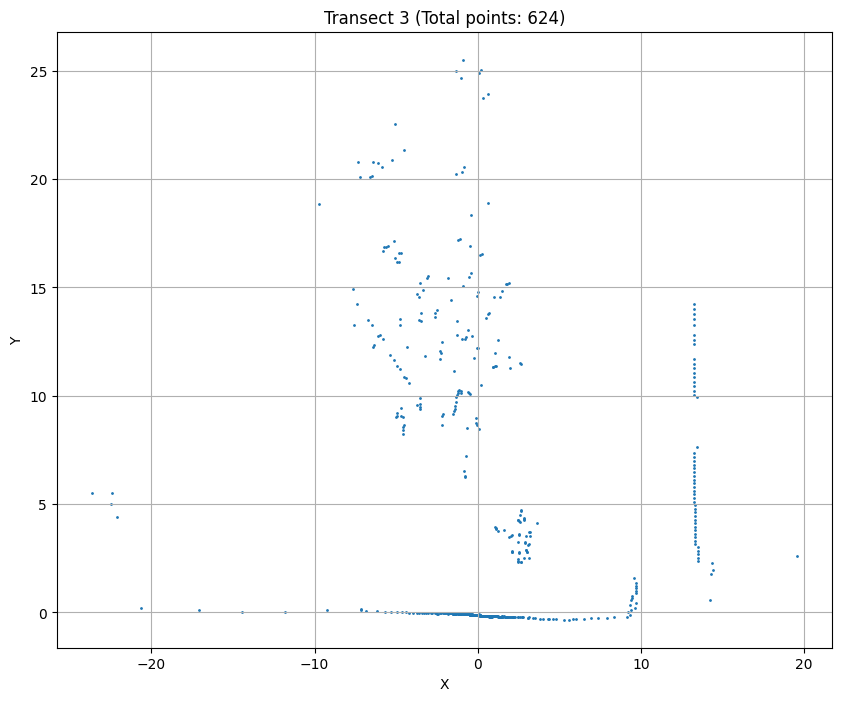

In [5]:

# # # Extract the rotation angle around the Z-axis
theta = np.arctan2(transformation_matrix[1, 0], transformation_matrix[0, 0])
print(theta)
# theta = 0.122*np.pi
# theta = 0.377209657321778
print(theta)


# # Create a reverse rotation matrix for the Z-axis
reverse_z_rotation = np.array([
    [np.cos(theta), np.sin(theta), 0, 0],
    [-np.sin(theta),  np.cos(theta), 0, 0],
    [0,               0,              1, 0],
    [0,0,0,1]
])

# # # Apply the reverse rotation around the Z-axis
transect_xyz_homogeneous = np.hstack((transect_transformed_df[['x', 'y', 'z']].values, np.ones((transect_transformed_df.shape[0], 1))))
# print(transect_xyz_homogeneous)
# print(transect_xyz_transformed.shape)
transect_xyz_transformed = transect_xyz_homogeneous.dot(reverse_z_rotation.T)[:, :3]
transect_transformed_df = pd.DataFrame(transect_xyz_transformed, columns=['x', 'y', 'z'])
############
# Extract the 2x2 rotation component (upper-left 2x2 submatrix)
# rotation_matrix_2x2 = transformation_matrix[:2, :2]

# # Compute the inverse of the 2x2 rotation matrix
# inverse_rotation_matrix_2x2 = np.linalg.inv(rotation_matrix_2x2)

# # Create a 4x4 rotation matrix with the inverse 2x2 rotation matrix
# inverse_rotation_matrix_4x4 = np.eye(4)
# inverse_rotation_matrix_4x4[:2, :2] = inverse_rotation_matrix_2x2

# # Apply the inverse rotation to the homogeneous coordinates
# transect_xyz_homogeneous = np.hstack((transect_transformed_df[['x', 'y', 'z']].values, np.ones((transect_transformed_df.shape[0], 1))))
# transect_xyz_transformed = transect_xyz_homogeneous.dot(inverse_rotation_matrix_4x4.T)[:, :3]
# transect_transformed_df = pd.DataFrame(transect_xyz_transformed, columns=['x', 'y', 'z'])
#############
# Extract the 2x2 rotation component (upper-left 2x2 submatrix)
# rotation_matrix_2x2 = transformation_matrix[:2, :2]

# # Create a 4x4 rotation matrix with the negative values of the 2x2 rotation component
# negative_rotation_matrix_4x4 = np.eye(4)
# negative_rotation_matrix_4x4[:2, :2] = -rotation_matrix_2x2

# # Apply the negative rotation to the homogeneous coordinates
# transect_xyz_homogeneous = np.hstack((transect_transformed_df[['x', 'y', 'z']].values, np.ones((transect_transformed_df.shape[0], 1))))
# transect_xyz_transformed = transect_xyz_homogeneous.dot(negative_rotation_matrix_4x4.T)[:, :3]
# transect_transformed_df = pd.DataFrame(transect_xyz_transformed, columns=['x', 'y', 'z'])

# Plot the transformed transect
plt.figure(figsize=(10, 8))
plt.scatter(transect_transformed_df['y'], transect_transformed_df['z'], s=1)
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'Transect {A} (Total points: {transect_point_counts[f"Transect {A}"]})')
plt.grid(True)
plt.show()

In [6]:
print(transect_transformed_df)

            x         y          z
0   -2.048099  1.890710  11.790126
1   -2.088835  1.948903  11.296994
2   -2.683025  2.584020  11.492089
3   -2.746219  2.653087  11.461118
4   -1.039313  1.030893   3.932242
..        ...       ...        ...
619  0.013285 -0.476935  16.911620
620 -0.315589 -0.056030  14.584110
621 -0.694473  0.055864  24.871512
622 -0.843652  0.211287  25.051062
623 -1.748711  1.480167  14.832845

[624 rows x 3 columns]


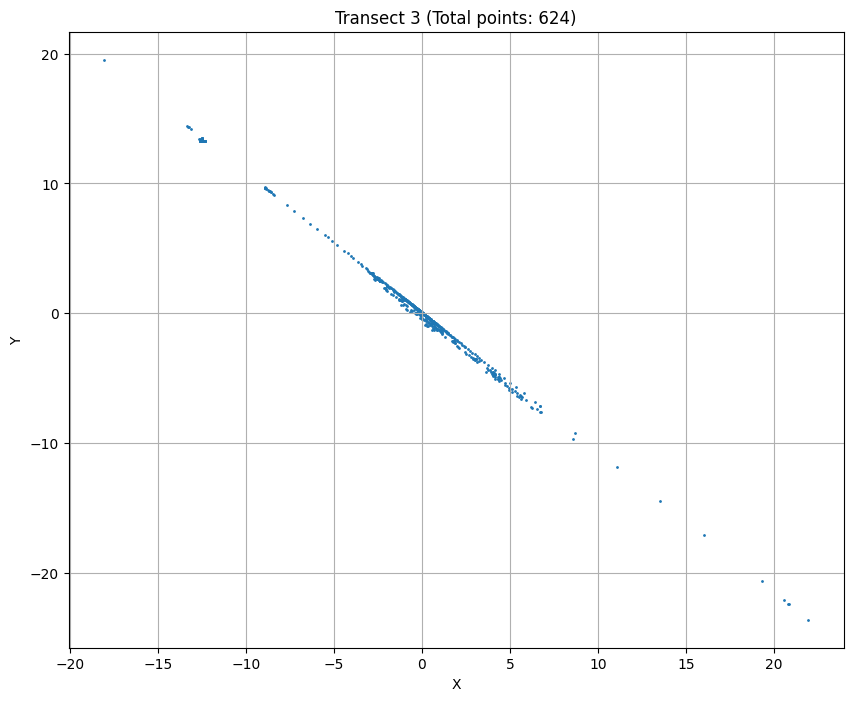

In [7]:
# Plot the transformed transect
plt.figure(figsize=(10, 8))
plt.scatter(transect_transformed_df['x'], transect_transformed_df['y'], s=1)
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'Transect {A} (Total points: {transect_point_counts[f"Transect {A}"]})')
plt.grid(True)
plt.show()

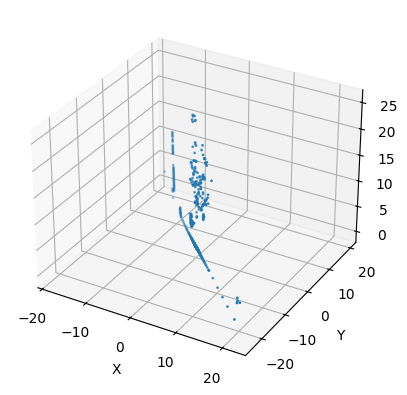

In [8]:
# # Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(transect_transformed_df['x'], transect_transformed_df['y'], transect_transformed_df['z'], s=1)

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show plot
plt.show()

## Transects ##

We first are going to label and or remove transects that we do not need. 

C:\Users\ruro\AppData\Local\Temp\ipykernel_13972\1041234916.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', 16)


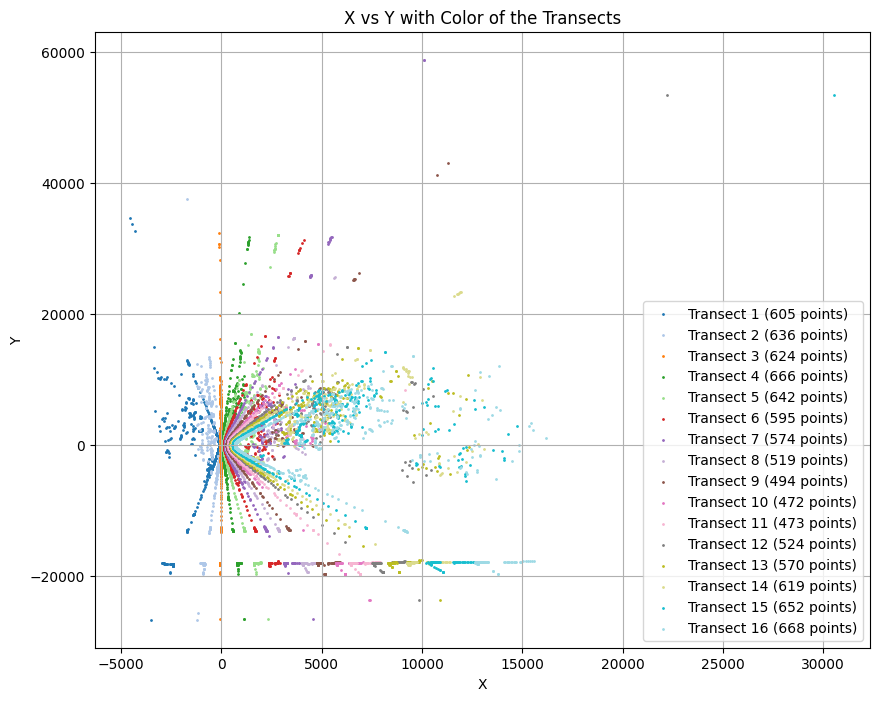

In [9]:
# Extract points as a NumPy array and apply rotation
xyz = np.asarray(pcd.points)
theta = np.pi / 2  # 90 degrees in radians
rotation_matrix = np.array([[np.cos(theta), 0, np.sin(theta)], [0, 1, 0], [-np.sin(theta), 0, np.cos(theta)]])
xyz_rotated = xyz.dot(rotation_matrix.T)

# Convert to spherical coordinates with the x-axis as the reference axis
x, y, z = xyz_rotated[:, 0], xyz_rotated[:, 1], xyz_rotated[:, 2]
rho = np.sqrt(x**2 + y**2 + z**2)
phi = np.arctan2(y, z)
theta_degrees = np.degrees(np.arccos(x / rho))

# Create a DataFrame to store the point cloud data along with theta values
point_cloud_df = pd.DataFrame({'x': x, 'y': y, 'z': z, 'theta': theta_degrees})

# Define the target theta2 values for each transect
target_theta2_values = [97.2, 92.5, 90.0, 87.6, 84.9, 82.7, 80.4, 77.9, 75.7, 73.0, 70.9, 68.0, 66.0, 63.4, 60.9, 55.7]

# Generate transects with theta2 values around the specified target values with increased range
transects = create_transects_around_target_theta2(point_cloud_df, target_theta2_values, theta_range=1)

# Rename the transects starting from 1 going to 16
transect_names = [f'Transect {i}' for i in range(1, 17)]
transect_dict = dict(zip(transect_names, transects))

# Count the number of points in each transect
transect_point_counts = {name: len(transect) for name, transect in transect_dict.items()}

# Check for unassigned points
unassigned_points_count = check_unassigned_points(point_cloud_df, transects)
if unassigned_points_count > 0:
    print(f"Unassigned points count: {unassigned_points_count}")

# Plot x vs y with color of the transects
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('tab20', 16)

for i, (name, transect) in enumerate(transect_dict.items()):
    plt.scatter(transect['x'], transect['y'], color=colors(i), label=f"{name} ({transect_point_counts[name]} points)", s=1)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('X vs Y with Color of the Transects')
plt.grid(True)
plt.legend()
plt.show()

## RD Coordinates ##

We transfrom the point cloud to RD-coordinate system, so that we can compare the point cloud with the lidar drone and individual GPS (GNSS) measuremetns. We obtain the Transformation matrix from the cloudcompare georeferencing. 

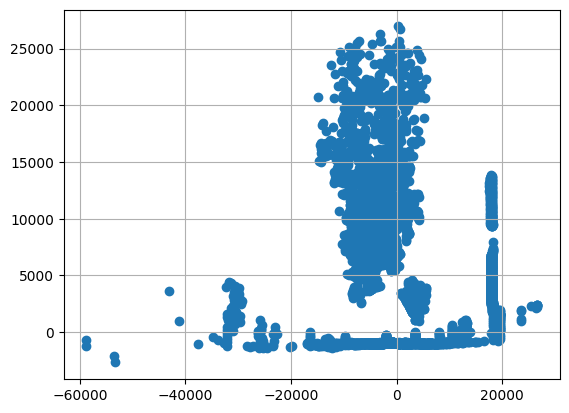

In [10]:
# Extract points as a NumPy array
xyz = np.asarray(pcd.points)
x = xyz[:, 0]
y = xyz[:, 1]
z = xyz[:, 2]

plt.scatter(-y,-x)
plt.grid()

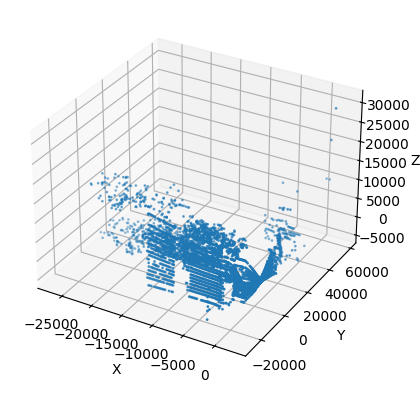

In [11]:
# Extract points as a NumPy array
xyz = np.asarray(pcd.points)
x = xyz[:, 0]
y = xyz[:, 1]
z = xyz[:, 2]


# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x,y,z, s=1)

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show plot
plt.show()

In [12]:
## Transformation matrix (CloudCompare)
# With scale + offset 
transformation_matrix = np.array([
    [2.9116514e-05, 0.000371316622, -0.0009284431, (644.85302734375 + 85000)],
    [-1.1219916e-05, -0.000928656838, -0.000371753966, (992.743286132813 + 445000)],
    [-0.000999878626, 2.123348e-05, -2.2864835e-05, 0.827817559242],
    [0.0, 0.0, 0.0, 1.0]
])


pcd = pcd.transform(transformation_matrix)

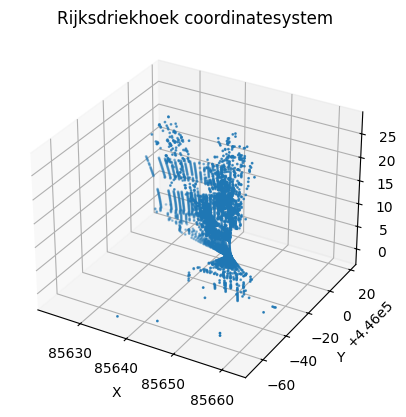

In [13]:
# Extract points as a NumPy array
xyz = np.asarray(pcd.points)
x = xyz[:, 0]
y = xyz[:, 1]
z = xyz[:, 2]


# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x,y,z, s=1)

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title(f'Rijksdriekhoek coordinatesystem')

# Show plot
plt.show()

In [14]:
# Compute the translation back offsets for X and Y only
translation_back = np.eye(4)
translation_back[0, 3] = -transformation_matrix[0, 3]
translation_back[1, 3] = -transformation_matrix[1, 3]

# Apply the translation back to the origin for X and Y
pcd.transform(translation_back)

# Extract the rotation angle around the Z-axis
theta_z = np.arctan2(transformation_matrix[1, 0], transformation_matrix[0, 0])

# Create a reverse rotation matrix for the Z-axis
cos_theta_z = np.cos(theta_z)
sin_theta_z = np.sin(theta_z)
rotation_z_matrix = np.array([
    [cos_theta_z, -sin_theta_z, 0, 0],
    [sin_theta_z, cos_theta_z,  0, 0],
    [0,           0,            1, 0],
    [0,           0,            0, 1]
])

# Apply the reverse rotation around the Z-axis
pcd.transform(rotation_z_matrix)

PointCloud with 9333 points.

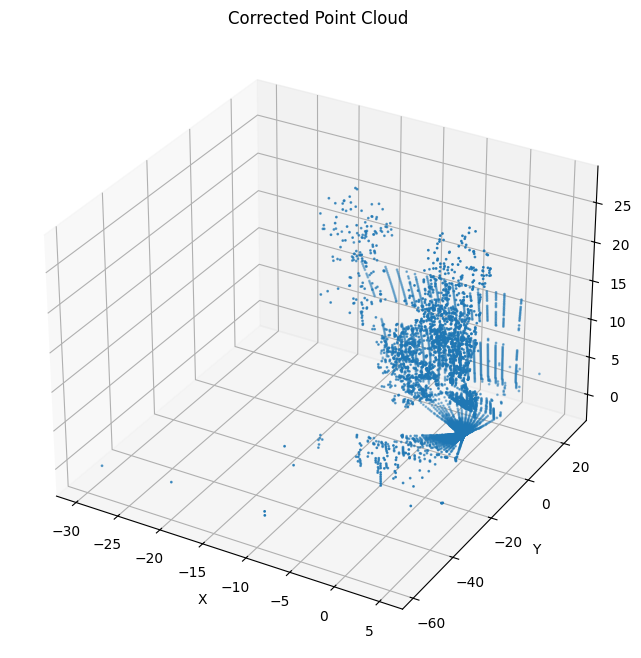

In [15]:
# Visualize the corrected point cloud
xyz = np.asarray(pcd.points)
x = xyz[:, 0]
y = xyz[:, 1]
z = xyz[:, 2]

# Create a 3D scatter plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, s=1)

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Corrected Point Cloud')

plt.show()

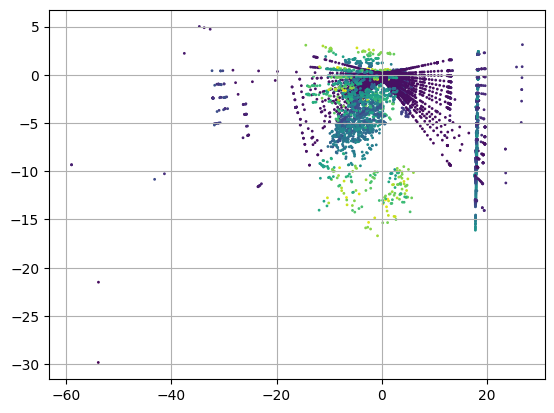

In [16]:
# Visualize the corrected point cloud
xyz = np.asarray(pcd.points)
longshore = xyz[:, 0]
crosshore = xyz[:, 1]
z = xyz[:, 2]

plt.scatter(crosshore,longshore, c=z, s=1)
plt.grid()

## Transects ##
Now that we have transformed the matrix to RD-coordinates and rotated it back to the new coordinate system (longshore, crosshore, NAP), we can filter the transects and further investigate Transect_03 as this is the zero degree transect (Crosshore orientated). 

In [17]:
# Convert to spherical coordinates with the x-axis as the reference axis
x, y, z = xyz[:, 0], xyz[:, 1], xyz[:, 2]
rho = np.sqrt(x**2 + y**2 + z**2)
phi = np.arctan2(y, z)
theta_degrees = np.degrees(np.arccos(x / rho))

# Create a DataFrame to store the point cloud data along with theta values
point_cloud_df = pd.DataFrame({'x': x, 'y': y, 'z': z, 'theta': theta_degrees})

# Define the target theta2 values for each transect
target_theta2_values = [97.2, 92.5, 90.0, 87.6, 84.9, 82.7, 80.4, 77.9, 75.7, 73.0, 70.9, 68.0, 66.0, 63.4, 60.9, 55.7]

# Generate transects with theta2 values around the specified target values with increased range
transects = create_transects_around_target_theta2(point_cloud_df, target_theta2_values, theta_range=3)

# Rename the transects starting from 1 going to 16
transect_names = [f'Transect {i}' for i in range(1, 17)]
transect_dict = dict(zip(transect_names, transects))

# Count the number of points in each transect
transect_point_counts = {name: len(transect) for name, transect in transect_dict.items()}

# Check for unassigned points
unassigned_points_count = check_unassigned_points(point_cloud_df, transects)
if unassigned_points_count > 0:
    print(f"Unassigned points count: {unassigned_points_count}")

# Calculate and print the average value of each transect
for name, transect in transect_dict.items():
    avg_x = transect['x'].mean()
    avg_y = transect['y'].mean()
    avg_z = transect['z'].mean()
    avg_theta = transect['theta'].mean()
    print(f"{name} - Average x: {avg_x}, Average y: {avg_y}, Average z: {avg_z}, Average theta: {avg_theta}")


Unassigned points count: 5664
Transect 1 - Average x: -1.1735086402014903, Average y: -0.4291550409601728, Average z: 5.207949374676926, Average theta: 97.21662658633046
Transect 2 - Average x: -0.42469096161037073, Average y: 0.11058551387018128, Average z: 5.6676734282702625, Average theta: 92.49839618708471
Transect 3 - Average x: 0.01808164699251556, Average y: 0.9897236175224076, Average z: 5.271860939837136, Average theta: 89.98695996155892
Transect 4 - Average x: 0.18566296603573143, Average y: 0.934130203082489, Average z: 3.979823932229496, Average theta: 88.00636876560927
Transect 5 - Average x: 0.6499662408880915, Average y: 1.45051349589592, Average z: 3.455365212409146, Average theta: 84.83512113894847
Transect 6 - Average x: 0.7925502926228406, Average y: 1.1264796410733027, Average z: 3.813306958303501, Average theta: 83.15451505803084
Transect 7 - Average x: 0.4632173079386275, Average y: 0.3724737664205978, Average z: 0.08214292677260002, Average theta: 81.050656620352

C:\Users\ruro\AppData\Local\Temp\ipykernel_13972\1383488488.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', 16)


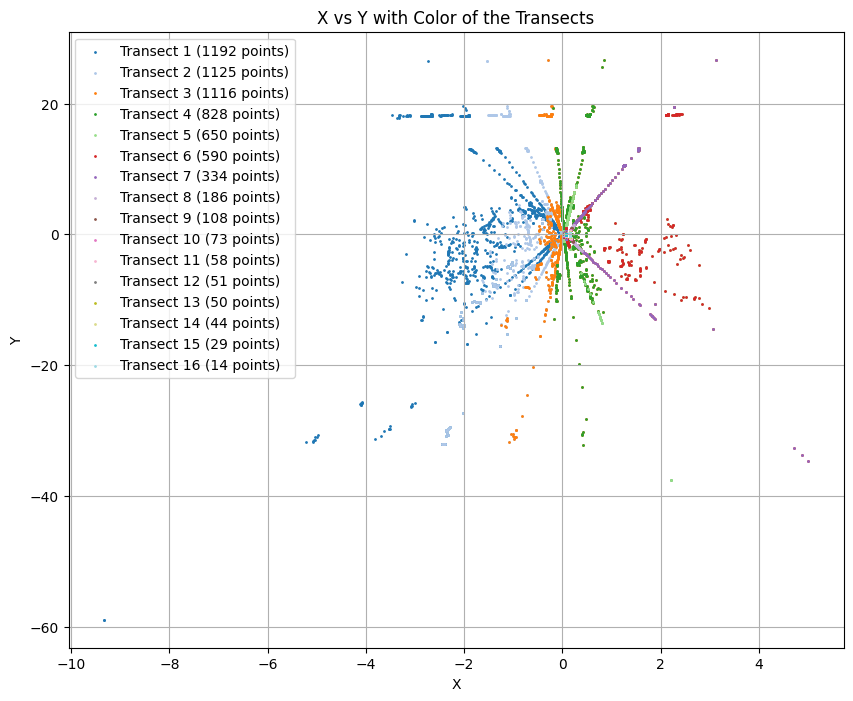

In [18]:
# Plot x vs y with color of the transects
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('tab20', 16)

for i, (name, transect) in enumerate(transect_dict.items()):
    plt.scatter(transect['x'], transect['y'], color=colors(i), label=f"{name} ({transect_point_counts[name]} points)", s=1)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('X vs Y with Color of the Transects')
plt.grid(True)
plt.legend()
plt.show()
